Welcome to the hands-on lab for **Building an Image**. You are now at the build step, which is the next to last step in your CD pipeline. Before you can deploy your application, you need to build a Docker image and push it to an image registry. Luckily, there is a `ClusterTask` from the Tekton catalog available on your cluster that can do that – the `buildah` `ClusterTask`.

# Learning Objectives

After completing this lab, you will be able to:
* Determine which ClusterTasks are available on your cluster
* Describe the parameters required to use the buildah ClusterTask
* Use the buildah ClusterTask in a Tekton pipeline to build an image and push it to an image registry

# Set Up the Lab Environment

## Clone the Code Repo

Now, get the code that you need to test. 

To do this, use the `git clone` command to clone the Git repository:
```
git clone https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git
```

**Your output should look similar to the image below:**

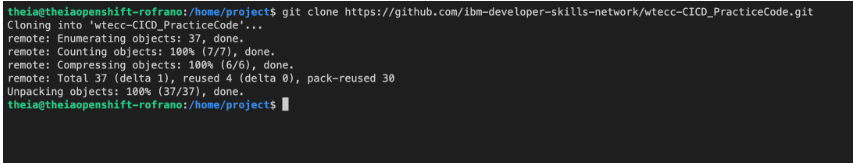

## Change to the Labs Directory

Once you have cloned the repository, change to the labs directory.
```
cd wtecc-CICD_PracticeCode/labs/05_build_an_image/
```

You are now ready to start the lab.

# Prerequisites

If you did not compete the previous labs, you will need to run the following commands to catch up and prepare your environment for this lab. If you have completed the previous labs, you may skip this step, although repeating it will not harm anything because Kubernetes is declarative and idempotent. It will always put the system in the same state given the same commands.

Issue the following commands to install everything from the previous labs.
```
tkn hub install task git-clone
```

**Note:** If the above command returns a error due to Tekton Version mismatch, please run the below command to fix this.

```
kubectl apply -f https://raw.githubusercontent.com/tektoncd/catalog/main/task/git-clone/0.9/git-clone.yaml
```
```
tkn hub install task flake8
kubectl apply -f tasks.yaml
```

**Check that you have all of the previous tasks installed:** `tkn task ls`

You should see:

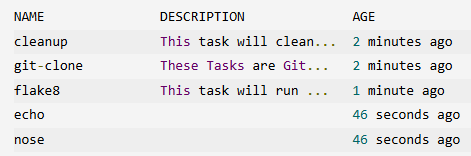

You are now ready to continue with this lab.

# Step 1: Check for ClusterTasks

Your pipeline currently has a placeholder for a `build` step that uses the `echo` task. Now it is time to replace it with a real image builder.

You search Tekton Hub for the word **"build"** and you see there is a task called `buildah` that will build images so you decide to use the `buildah` task in your pipeline to build your code.

Instead of installing it yourself, you first check the **ClusterTasks** in your cluster to see if it already exists. Luckily, the OpenShift environment you are using already has `buildah` installed as a `ClusterTask`. A `ClusterTask` is installed cluster-wide by an administrator and anyone can use it in their pipelines without having to install it themselves.

Check that the `buildah` task is installed as a `ClusterTask` using the **Tekton CLI**.
```
tkn clustertask ls
```

You should see the `buildah` task in the list with all the other available ClusterTasks.

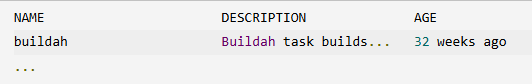

If you see it, you are ready to proceed.

# Step 2: Add a Workspace to the Pipeline Task

Now you will update the `pipeline.yaml` file to use the new `buildah` task.

Open `pipeline.yaml` in the editor. To open the editor, click the button below.

In reading the documentation for the `buildah` task, you will notice that it requires a workspace named `source`.

## Your Task

Add the workspace to the `build` task after the name, but before the `taskRef`. The workspace that you have been using is named `pipeline-workspace` and the name the task requires is `source`.

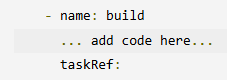


## Solution

```
    - name: build
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
```

# Step 3: Reference the buildah Task

Now, you need to reference the new buildah task that you want to use. In the previous steps, you simply changed the name of the reference to the task. But since the `buildah` task is a **ClusterTask**, you need to add the statement `kind:` **ClusterTask** under the name so that Tekton knows to look for a **ClusterTask** and not a regular **Task**.

## Your Task

Change the `taskRef` from `echo` to reference the `buildah` task and add a line below it with `kind: ClusterTask` to indicate that this is a `ClusterTask`.

## Solution

```
      taskRef:
        name: buildah
        kind: ClusterTask
```

# Step 4: Update the Task Parameters

The documentation for the buildah task details several parameters but only one of them is required. You need to use the `IMAGE` parameter to hold the name of the image you want to build.

Since you might want to reuse this pipeline to build different images, you will make it a variable parameter that can be passed in when the pipeline runs. To do this, you need to change it here and add a parameter to the Pipeline itself.

## Your Task

Change the message parameter to `IMAGE` and specify the value of `$(params.build-image)`.

## Solution 1

```
      params:
      - name: IMAGE
        value: "$(params.build-image)"
```

Now that you are passing in the `IMAGE` parameter to this task, you need to go back to the top of the `pipeline.yaml` file and add the parameter there so that it can be passed into the pipeline when it is run.

Add a parameter named `build-image` to the existing list of parameters at the top of the pipeline under `spec.params`.

## Solution 2

```
spec:
  params:
    - name: build-image
```

# Step 5: Check Your Work

## Code Check

If you changed everything correctly, the full `build` task in the pipeline should look like this:

```
    - name: build
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
        name: buildah
        kind: ClusterTask
      params:
      - name: IMAGE
        value: "$(params.build-image)"
      runAfter:
        - tests
```

Save your changes before you continue.

## Terminal Folder Check

Before you proceed with running commands in the terminal, make sure that you are in the `/home/project/wtecc-CICD_PracticeCode/labs/05_build_an_image` folder.

Go to the terminal and use the `pwd` command just to be sure.
```
pwd
```

You should see: `/home/project/wtecc-CICD_PracticeCode/labs/05_build_an_image`. If you do not, you should `cd` into that folder now:
```
cd /home/project/wtecc-CICD_PracticeCode/labs/05_build_an_image
```

You are now ready to execute the terminal commands in the next step.

# Step 6: Apply Changes and Run the Pipeline

## Apply the Pipeline

Apply the same changes you just made to `pipeline.yaml` to your cluster:
```
kubectl apply -f pipeline.yaml
```

## Apply the PVC

Next, make sure that the persistent volume claim for the workspace exists by applying it using `kubectl`:
```
kubectl apply -f pvc.yaml
```

## Start the Pipeline

When you start the pipeline, you need to pass in the `build-image` parameter, which is the name of the image to build.

This will be different for every learner that uses this lab. Here is the format:
```
image-registry.openshift-image-registry.svc:5000/$SN_ICR_NAMESPACE/tekton-lab:latest
```

Notice the variable `$SN_ICR_NAMESPACE` in the image name. This is automatically set to point to your container namespace.

Now, start the pipeline to see your new build task run. Use the Tekton CLI `pipeline start` command to run the pipeline, passing in the parameters `repo-url`, `branch`, and `build-image` using the `-p` option. Specify the workspace `pipeline-workspace` and volume claim `pipelinerun-pvc` using the `-w` option:
```
tkn pipeline start cd-pipeline \
    -p repo-url="https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git" \
    -p branch=main \
    -p build-image=image-registry.openshift-image-registry.svc:5000/$SN_ICR_NAMESPACE/tekton-lab:latest \
    -w name=pipeline-workspace,claimName=pipelinerun-pvc \
    --showlog
```

You should see `Waiting for logs to be available...` while the pipeline runs. The logs will be shown on the screen. Wait until the pipeline run completes successfully.

## Check the Run Status

**You can see the pipeline run status by listing the pipeline runs with:** `tkn pipelinerun ls`

**You should see:**

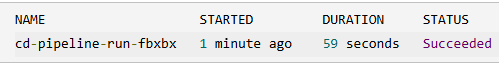

**You can check the logs of the last run with:** `tkn pipelinerun logs --last`

# Conclusion

Congratulations! 

You have just added the ability to build a Docker image and push it to the image registry in OpenShift.

In this lab, you learned how to use the `buildah` `ClusterTask` from the Tekton catalog. You learned how to modify your pipeline to reference the task as a `ClusterTask` and configure its parameters. You also learned how to pass additional parameters to a pipeline, how to run it to build an image, and how to push the image to an image registry in OpenShift.